## Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import shap
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, precision_score, recall_score, precision_recall_curve
random.seed(123)

## Loading data

In [2]:
# Loading data
df = pd.read_csv('SP/dataset_ML_SP.csv')
df_tplot = df['tplot']
df_cases = df['CASES_100K']
df = df.drop(columns = ['EPI_YEAR','tplot','CASES_100K'])
df['label_2'] = 0 # for most of values, no epidemic yet
df.loc[df['label'] == 'Epi','label_2'] = 1 # epidemic
df.loc[df['label'] == 'High','label_2'] = 1 # epidemic as well
df = df.drop(columns = ['label'])

## Train-test split

In [3]:
df

,EPI_WEEK,rh_max_lag,rh_min_lag,t_min_lag,t_max_lag,p_total_lag,LAMBDA_lag,label_2
0,20,99.222857,63.656667,18.744286,27.047143,48.88,0.334046,0
1,21,97.115714,63.321429,19.170000,27.095714,7.34,0.618988,0
2,22,98.205714,58.884286,20.170000,25.968571,11.61,0.688747,0
3,23,99.571429,72.187143,20.297143,27.425714,1.08,0.753158,0
4,24,99.901429,68.365714,19.322857,27.914286,1.87,0.771134,0
...,...,...,...,...,...,...,...,...
1072,48,93.911429,21.767143,10.398571,29.857143,14.94,0.195175,0
1073,49,94.374286,35.588571,11.587143,31.302857,20.14,1.041147,0
1074,50,96.572857,39.402857,13.977143,30.122857,77.46,0.731808,0
1075,51,97.687143,42.984286,14.841429,31.821429,10.60,0.610595,0


In [4]:
X = df.iloc[:,0:7]
y = df.iloc[:,7]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test, test_size = 0.5, random_state = 0)

In [5]:
print('Train: ', y_train.shape)
print('Test: ', y_test.shape)
print('Validation: ', y_val.shape)

Train:  (753,)
Test:  (162,)
Validation:  (162,)


## Doing hyperparameter tuning for XGBoost Classifier

In [6]:
hyperparameter_grid = {
    'n_estimators': [10, 50, 100, 200, 400],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.05, 0.07, 0.1, 0.2, 0.3],
    'gamma': [0, 0.01, 0.1, 1, 10],
    'min_child_weight': [0, 1, 2]
    }

clx = XGBClassifier(random_state = 0, nthread = 8)
grid = GridSearchCV(clx, hyperparameter_grid, cv = 5, scoring="roc_auc")
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=8,
                                     num_parallel_tree=None, ...),
             param_grid={'gamma': [0, 0.01, 0.1, 1, 10],
                         'learning_rate': [0.05, 0.07, 0.1, 0.2, 0.3],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_child_weight': [0, 1, 2],
                         'n_estimators': [10, 50, 100, 200, 400]},
             scoring='roc_auc')

In [7]:
import joblib
joblib.dump(grid, 'sp_ccm.pkl')

['sp_ccm.pkl']

In [9]:
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.955075488049626 with param: {'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 50}


### Tuning the threshold

In [10]:
y_val_pred = grid.predict(X_val)
y_val_proba = grid.predict_proba(X_val)[:,1]

In [11]:
roc_auc_score(y_val, y_val_proba)

0.8903225806451613

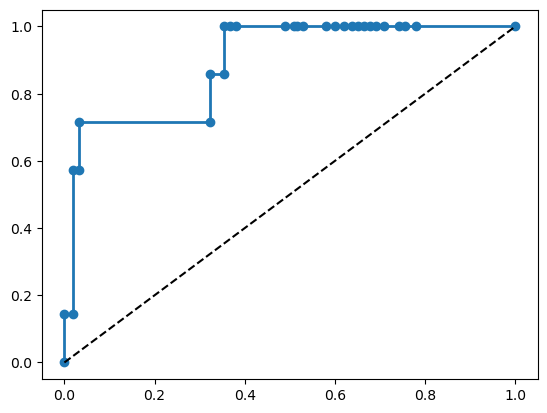

In [12]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba, pos_label = 1)
plt.plot(fpr, tpr, '-o', linewidth=2)
plt.plot([0,1], [0,1], 'k--' )

In [13]:
print(fpr)
print(tpr)
print(thresholds)

[0.         0.         0.01935484 0.01935484 0.03225806 0.03225806
 0.32258065 0.32258065 0.35483871 0.35483871 0.36774194 0.38064516
 0.49032258 0.50967742 0.51612903 0.52903226 0.58064516 0.6
 0.61935484 0.63870968 0.6516129  0.66451613 0.67741935 0.69032258
 0.70967742 0.74193548 0.75483871 0.78064516 1.        ]
[0.         0.14285714 0.14285714 0.57142857 0.57142857 0.71428571
 0.71428571 0.85714286 0.85714286 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]
[1.7392441  0.7392441  0.49211454 0.21777342 0.14751993 0.14071442
 0.007805   0.00762679 0.00680706 0.00643009 0.00625649 0.00618996
 0.00403109 0.00400041 0.00368522 0.00368148 0.00317093 0.00300484
 0.00265528 0.00265372 0.00263451 0.00252817 0.0023659  0.00234836
 0.00220968 0.00219819 0.00215879 0.00206285 0.00205705]


In [14]:
thr_opt = thresholds[np.argmin(abs(tpr-1))]

In [15]:
thr_opt

0.0064300913

### Setting threshold and evaluating on test

In [16]:
y_test_pred = grid.predict(X_test)
y_test_proba = grid.predict_proba(X_test)[:,1]
y_test_final = y_test_proba.copy()
y_test_final[y_test_proba >= thr_opt] = 1
y_test_final[y_test_proba < thr_opt] = 0
print(confusion_matrix(y_test, y_test_final))
print('Test Metrics')
print('False Positive Rate: ', 34/(34 + 104))
print('True Positive Rate: ', 12/(12 + 0))

[[111  44]
 [  0   7]]
Test Metrics
False Positive Rate:  0.2463768115942029
True Positive Rate:  1.0


In [17]:
y_train_pred = grid.predict(X_train)
y_train_proba = grid.predict_proba(X_train)[:,1]
y_train_final = y_train_proba.copy()
y_train_final[y_train_proba >= thr_opt] = 1
y_train_final[y_train_proba < thr_opt] = 0
print(confusion_matrix(y_train, y_train_final))
print('Train Metrics')
print('False Positive Rate: ', 18/(18 + 166))
print('True Positive Rate: ', 16/(16))

[[484 237]
 [  0  32]]
Train Metrics
False Positive Rate:  0.09782608695652174
True Positive Rate:  1.0


In [18]:
y_val_pred = grid.predict(X_val)
y_val_proba = grid.predict_proba(X_val)[:,1]
y_val_final = y_val_proba.copy()
y_val_final[y_val_proba >= thr_opt] = 1
y_val_final[y_val_proba < thr_opt] = 0
print(confusion_matrix(y_val, y_val_final))
print('Validation Metrics')
print('False Positive Rate: ', 18/(18 + 120))
print('True Positive Rate: ', 12/(12 + 0))

[[100  55]
 [  0   7]]
Validation Metrics
False Positive Rate:  0.13043478260869565
True Positive Rate:  1.0


### Embedded Feature Importance 

Text(0.5, 0, 'Feature Importance')

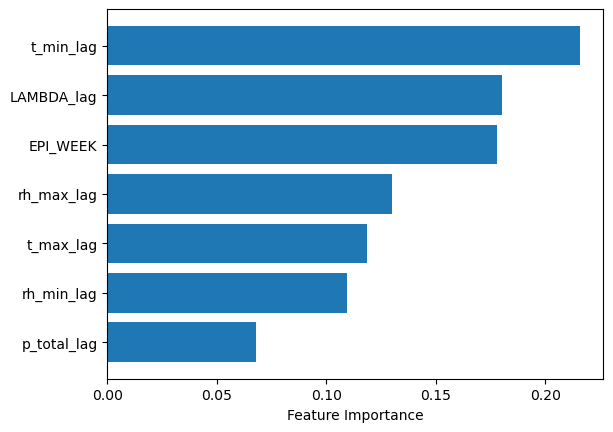

In [19]:
sorted_params = grid.best_estimator_.feature_importances_.argsort()
plt.barh(df.columns[sorted_params], grid.best_estimator_.feature_importances_[sorted_params])
plt.xlabel('Feature Importance')

### SHAP Values

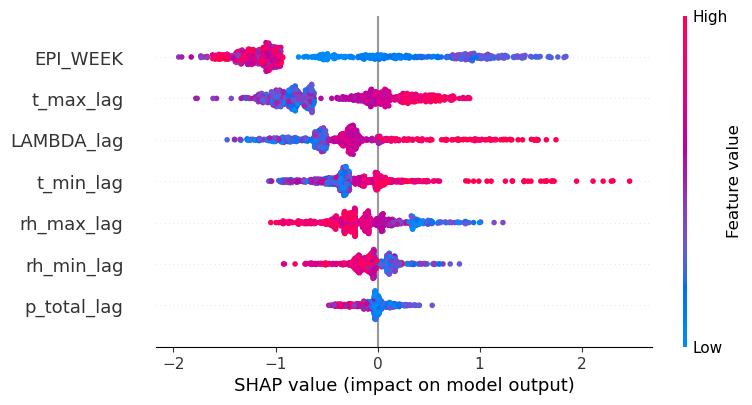

In [20]:
explainer = shap.Explainer(grid.best_estimator_)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)

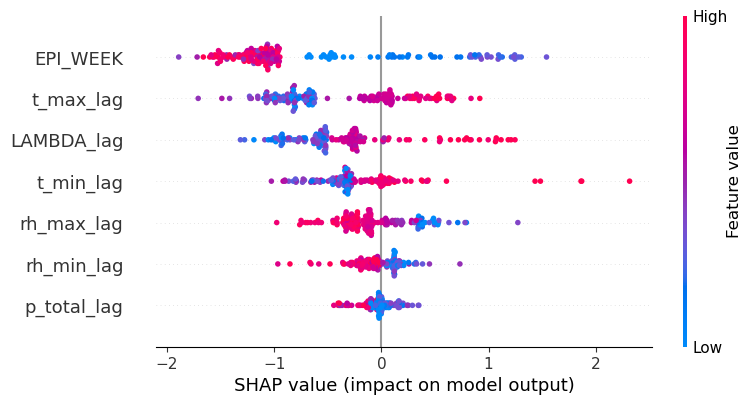

In [21]:
explainer = shap.Explainer(grid.best_estimator_)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)

## Visualizing predictions - where do we fail?

In [22]:
y_pred_proba = grid.predict_proba(X)[:,1]
y_pred_final = y_pred_proba.copy()
y_pred_final[y_pred_proba >= thr_opt] = 1
y_pred_final[y_pred_proba < thr_opt] = 0

In [23]:
roc_auc_score(y, y_pred_proba)

0.9821511407244972

In [24]:
confusion_matrix(y, y_pred_final)

array([[695, 336],
       [  0,  46]], dtype=int64)

In [25]:
print('True positive rate: ', 40/(40 + 6))
print('False positive rate: ', 193/(193 + 838))

True positive rate:  0.8695652173913043
False positive rate:  0.1871968962172648


### False negatives, which is what worries us the most

In [26]:
fn = ((y == 1) & (y_pred_final == 0))
sem_fn = X[fn]

In [27]:
sem_fn

,EPI_WEEK,rh_max_lag,rh_min_lag,t_min_lag,t_max_lag,p_total_lag,LAMBDA_lag


### False positives

In [28]:
fp = ((y == 0) & (y_pred_final == 1))
sem_fp = X[fp]

In [29]:
sem_fp['EPI_WEEK'].value_counts()

20    19
19    17
21    17
16    16
14    15
13    15
1     15
17    15
15    15
11    15
18    14
12    14
9     14
7     14
10    13
8     12
6     12
3     11
5      9
4      9
2      9
26     7
24     6
22     5
23     4
50     4
25     4
27     3
52     3
30     2
51     2
49     2
48     1
31     1
53     1
47     1
Name: EPI_WEEK, dtype: int64

### Classifying and labeling each situation

In [190]:
fn = ((y == 1) & (y_pred_final == 0))
fp = ((y == 0) & (y_pred_final == 1))
tn = ((y == 0) & (y_pred_final == 0))
tp = ((y == 1) & (y_pred_final == 1))

In [193]:
print(sum(fp))
print(sum(tp))

336
46


In [31]:
Z = X.copy()
Z['label'] = 0

In [32]:
Z.loc[fn,'label'] = 'FN'
Z.loc[fp,'label'] = 'FP'
Z.loc[tn,'label'] = 'TN'
Z.loc[tp, 'label'] = 'TP'

In [33]:
Z['tplot'] = np.array(df_tplot)
Z['CASES_100K'] = np.array(df_cases)

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


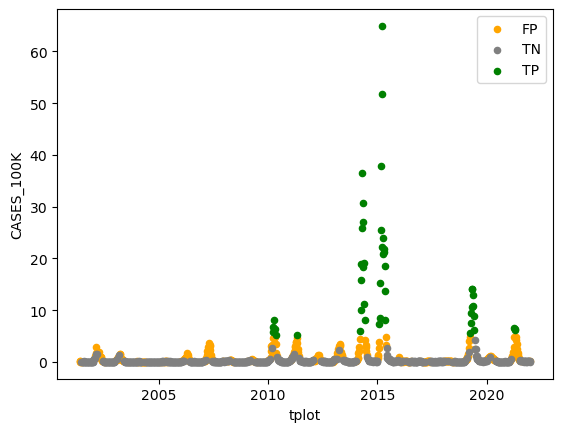

In [34]:
fig, ax = plt.subplots()

colors = {'TP':'green', 'TN':'gray', 'FP':'orange', 'FN':'red'}

grouped = Z.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='tplot', y='CASES_100K', label=key, color=colors[key])

plt.show()

In [35]:
Z['proba'] = y_pred_proba

Text(0, 0.5, 'Count')

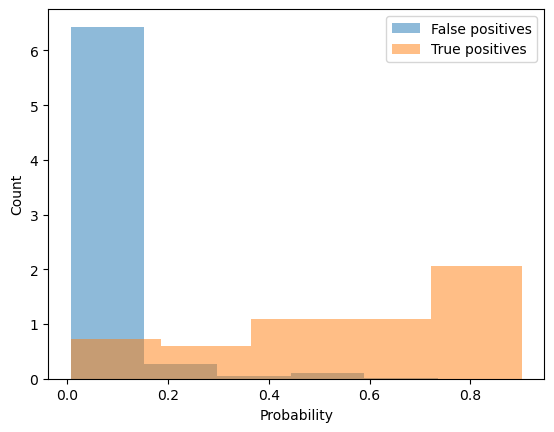

In [36]:
A = Z.copy()
A = A[A['label'] == 'FP']
B = Z.copy()
B = B[B['label'] == 'TP']
C = Z.copy()
C = C[C['label'] == 'TN']
plt.hist(A['proba'], bins = 5, alpha = 0.5, density = True, label = 'False positives')
plt.hist(B['proba'], bins = 5, alpha = 0.5, density = True, label = 'True positives')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Count')

In [37]:
roc_auc_score(y_val, y_val_proba)

0.8903225806451613

### Reclassifying TP and FP

In [291]:
pos_thr = np.arange(0,0.7,0.025)
tpp_vec = []
fpp_vec = []

In [292]:
thr_opt

0.0064300913

In [293]:
ex_sel = (y_pred_proba >= thr_opt) # selected examples

In [294]:
y_sel = y.loc[ex_sel] # getting all positives
y_sel_prob = y_pred_proba[ex_sel] # getting their probabilities

In [295]:
for thr in pos_thr:
    tpp_tmp = sum((y_sel_prob >= thr) & (y_sel == 1))/sum(y_sel_prob >= thr) # true positive proportion - true positives/all positives
    fpp_tmp = sum((y_sel_prob >= thr) & (y_sel == 0))/sum(y_sel_prob >= thr) # false positive proportion - false positives / all positives
    tpp_vec.append(tpp_tmp)
    fpp_vec.append(fpp_tmp)

0.07500000000000001
0.4888888888888889
0.5111111111111111


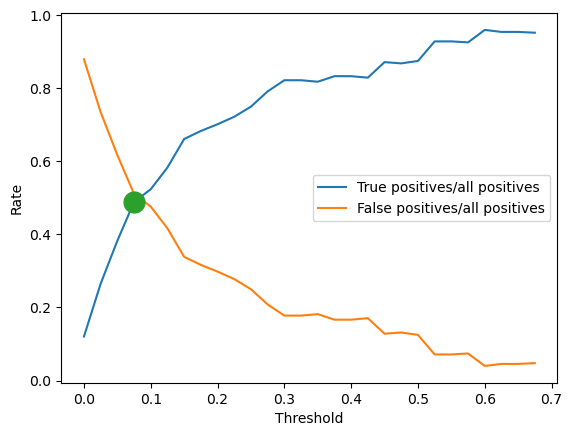

In [296]:
plt.plot(pos_thr, tpp_vec, label = 'True positives/all positives')
plt.plot(pos_thr, fpp_vec, label = 'False positives/all positives')
plt.legend()
thr_arg = np.argmin(abs(np.array(tpp_vec) - np.array(fpp_vec)))
thr_new = pos_thr[thr_arg]
print(thr_new)
print(tpp_vec[thr_arg])
print(fpp_vec[thr_arg])
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.plot(np.array([thr_new]),np.array([tpp_vec[thr_arg]]),'o', markersize = 15)
plt.show()

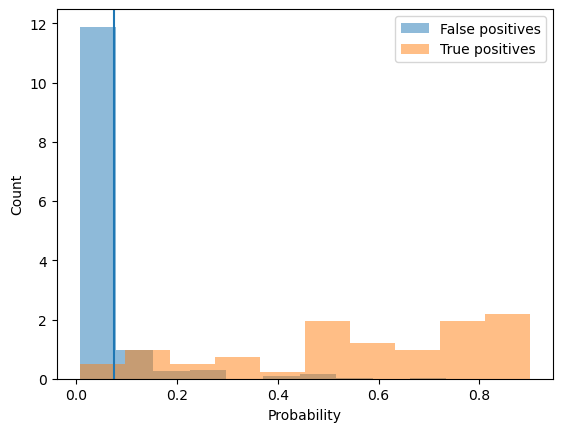

In [297]:
A = Z.copy()
A = A[A['label'] == 'FP']
B = Z.copy()
B = B[B['label'] == 'TP']
C = Z.copy()
C = C[C['label'] == 'TN']
plt.hist(A['proba'], bins = 10, alpha = 0.5, density = True, label = 'False positives')
plt.hist(B['proba'], bins = 10, alpha = 0.5, density = True, label = 'True positives')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Count')
plt.axvline(thr_new)

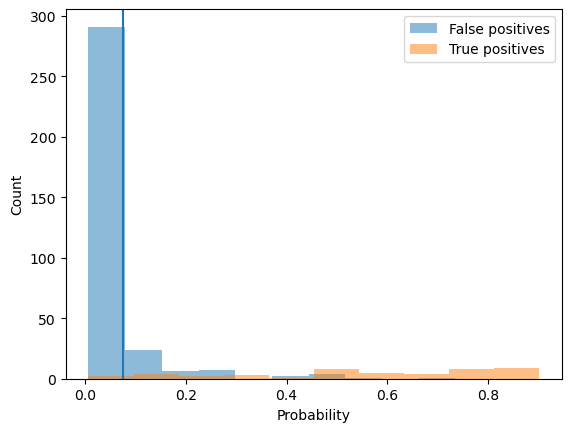

In [298]:
A = Z.copy()
A = A[A['label'] == 'FP']
B = Z.copy()
B = B[B['label'] == 'TP']
C = Z.copy()
C = C[C['label'] == 'TN']
plt.hist(A['proba'], bins = 10, alpha = 0.5,  label = 'False positives')
plt.hist(B['proba'], bins = 10, alpha = 0.5,  label = 'True positives')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Count')
plt.axvline(thr_new)

In [299]:
print(A.shape[0], sum(A['proba'] >= thr_new), 100*46/336)
print(B.shape[0], sum(B['proba'] >= thr_new), 100*44/46)

336 46 13.69047619047619
46 44 95.65217391304348
